<a href="https://colab.research.google.com/github/kinuthiaG/deep-learning-coursera/blob/master/__05_pet_breeds_19_8_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __CHAPTER 5 Image Classification__ `pet_breeds`

# [“fine_tune” vs. “fit_one_cycle"](https://forums.fast.ai/t/fine-tune-vs-fit-one-cycle/66029)
# <FONT COLOR=RED> Initially 3-3-2021 Rev 19-8-2022

In [1]:
!pwd # use fastai-2.7.9
# %load_ext autotime

/content


ModuleNotFoundError: No module named 'autotime'

In [ ]:
## copied after git cloned most currrent 14-8-2022 dated 3 MONTHS AGO

#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Image Classification

##### <FONT COLOR=RED> Now that you understand what deep learning is, what it's for, and how to create and deploy a model, it's time for us to go deeper! In an ideal world deep learning practitioners wouldn't have to know every detail of how things work under the hood… But as yet, we don't live in an ideal world. The truth is, to make your model really work, and work reliably, there are a lot of details you have to get right, and a lot of details that you have to check. This process requires being able to look inside your neural network as it trains, and as it makes predictions, find possible problems, and know how to fix them.

##### <FONT COLOR=RED> So, from here on in the book we are going to do a deep dive into the mechanics of deep learning. What is the architecture of a computer vision model, an NLP model, a tabular model, and so on? How do you create an architecture that matches the needs of your particular domain? How do you get the best possible results from the training process? How do you make things faster? What do you have to change as your datasets change?

##### <FONT COLOR=RED> We will start by repeating the same basic applications that we looked at in the first chapter, but we are going to do two things:

- __Make them better.__
- __Apply them to a wider variety of types of data.__

##### <FONT COLOR=RED> In order to do these two things, we will have to learn all of the pieces of the deep learning puzzle. This includes `different types of layers`, `regularization methods`, `optimizers`, `how to put layers together into architectures`, `labeling techniques`, `and much more`. We are not just going to dump all of these things on you, though; we will introduce them progressively as needed, to solve actual problems related to the projects we are working on.

## From Dogs and Cats to Pet Breeds

##### <FONT COLOR=RED> In our very first model we learned how to classify dogs versus cats. Just a few years ago this was considered a very challenging task—but today, it's far too easy! We will not be able to show you the nuances of training models with this problem, because we get a nearly perfect result without worrying about any of the details. But it turns out that the same dataset also allows us to work on a much more challenging problem: figuring out what breed of pet is shown in each image.

##### <FONT COLOR=RED> In `Chapter 1` we presented the applications as already-solved problems. But this is not how things work in real life. We start with some dataset that we know nothing about. We then have to figure out how it is put together, how to extract the data we need from it, and what that data looks like. For the rest of this book we will be showing you how to solve these problems in practice, including all of the intermediate steps necessary to understand the data that you are working with and test your modeling as you go.

##### <FONT COLOR=RED> We already downloaded the Pet dataset, and we can get a path to this dataset using the same code as in `Chapter 1`:

##### <FONT COLOR=RED> Now if we are going to understand how to extract the breed of each pet from each image we're going to need to understand how this data is laid out. Such details of data layout are a vital piece of the deep learning puzzle. Data is usually provided in one of these two ways:

- <FONT COLOR=RED> Individual files representing items of data, such as text documents or images, possibly organized into folders or with filenames representing information about those items
- <FONT COLOR=RED> A table of data, such as in CSV format, where each row is an item which may include filenames providing a connection between the data in the table and data in other formats, such as text documents and images

##### <FONT COLOR=RED> There are exceptions to these rules—particularly in domains such as genomics, where there can be binary database formats or even network streams—but overall the vast majority of the datasets you'll work with will use some combination of these two formats.

##### <FONT COLOR=RED> To see what is in our dataset we can use the `ls` method:

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [ ]:
#hide
Path.BASE_PATH = path

In [ ]:
path.ls() # NOTE NO 'models' FOLDER IN THIS

(#2) [Path('annotations'),Path('images')]

##### <FONT COLOR=RED> We can see that this dataset provides us with `images` and `annotations` directories. The [website](https://www.robots.ox.ac.uk/~vgg/data/pets/) for the dataset tells us that the `annotations` directory contains information about where the pets are rather than what they are. In this chapter, we will be doing classification, not localization, which is to say that we care about what the pets are, not where they are. Therefore, we will ignore the *annotations* directory for now. So, let's have a look inside the `images` directory:

In [ ]:
(path/"images").ls()

(#7393) [Path('images/samoyed_67.jpg'),Path('images/basset_hound_56.jpg'),Path('images/american_pit_bull_terrier_49.jpg'),Path('images/beagle_170.jpg'),Path('images/Ragdoll_35.jpg'),Path('images/pomeranian_142.jpg'),Path('images/saint_bernard_58.jpg'),Path('images/yorkshire_terrier_158.jpg'),Path('images/chihuahua_87.jpg'),Path('images/wheaten_terrier_116.jpg')...]

In [ ]:
list((path/'images').ls())[:5] # Not using L class to show a list of 1st 5 items.

[Path('images/samoyed_67.jpg'),
 Path('images/basset_hound_56.jpg'),
 Path('images/american_pit_bull_terrier_49.jpg'),
 Path('images/beagle_170.jpg'),
 Path('images/Ragdoll_35.jpg')]

##### <FONT COLOR=RED> Most functions and methods in fastai that return a collection use a class called `L`. This class can be thought of as an enhanced version of the ordinary Python `list` type, with added conveniences for common operations. For instance, when we display an object of this class in a notebook it appears in the format shown there. The first thing that is shown is the number of items in the collection, prefixed with a `#`. You'll also see in the preceding output that the list is suffixed with an ellipsis. This means that only the first few items are displayed—which is a good thing, because we would not want more than 7,000 filenames on our screen!

##### <FONT COLOR=RED> By examining these filenames, we can see how they appear to be structured. Each filename contains the pet breed, and then an underscore (`_`), a number, and finally the file extension. We need to create a piece of code that extracts the breed from a single `Path`. Jupyter notebooks make this easy, because we can gradually build up something that works, and then use it for the entire dataset. We do have to be careful to not make too many assumptions at this point. For instance, if you look carefully you may notice that some of the pet breeds contain multiple words, so we cannot simply break at the first `_` character that we find. To allow us to test our code, let's pick out one of these filenames:

In [ ]:
fname = (path/"images").ls()[0]

In [ ]:
fname, fname.name

(Path('images/samoyed_67.jpg'), 'samoyed_67.jpg')

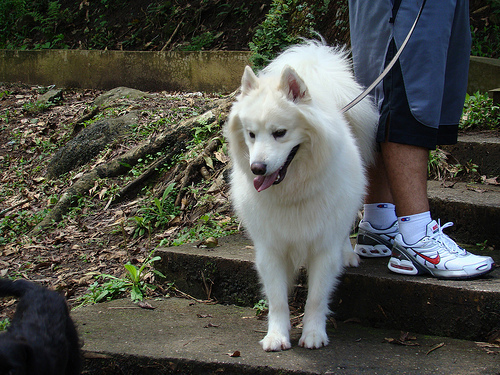

In [ ]:
img = PILImage.create((path/"images").ls()[0])
img

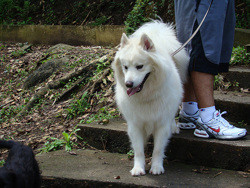

In [ ]:
img.to_thumb(250)

### <FONT COLOR=REDD> A small detour on converting image to tensor OR array

In [ ]:
array(img)

array([[[ 5, 28,  0],
        [15, 44,  0],
        [18, 60, 22],
        ...,
        [30, 43, 26],
        [26, 37, 21],
        [23, 31, 16]],

       [[24, 38, 13],
        [23, 65, 25],
        [27, 60, 31],
        ...,
        [27, 46, 27],
        [32, 49, 31],
        [25, 39, 22]],

       [[14, 43, 21],
        [18, 32, 17],
        [23, 46, 28],
        ...,
        [23, 34, 18],
        [27, 41, 24],
        [33, 50, 32]],

       ...,

       [[ 7,  7,  9],
        [ 6,  6,  8],
        [ 4,  4,  4],
        ...,
        [92, 84, 81],
        [59, 49, 39],
        [77, 72, 52]],

       [[ 6,  6,  6],
        [ 5,  5,  5],
        [ 3,  3,  3],
        ...,
        [64, 53, 67],
        [50, 38, 48],
        [24, 18, 18]],

       [[ 4,  4,  2],
        [ 3,  3,  1],
        [ 2,  2,  0],
        ...,
        [43, 35, 33],
        [38, 27, 35],
        [19, 14, 18]]], dtype=uint8)

In [ ]:
doc(ToTensor)

---

### ToTensor

>      ToTensor (enc=None, dec=None, split_idx=None, order=None)

Convert item to appropriate tensor class

<a href="https://docs.fast.ai/data.transforms.html#totensor" target="_blank" rel="noreferrer noopener">Show in docs</a>

In [ ]:
## EXTRA FROM https://www.projectpro.io/recipes/convert-image-tensor-pytorch
## CHECK fastai SOLUTION LATER

from torchvision import transforms
convert_tensor = transforms.ToTensor()
convert_tensor(img)

tensor([[[0.0196, 0.0588, 0.0706,  ..., 0.1176, 0.1020, 0.0902],
         [0.0941, 0.0902, 0.1059,  ..., 0.1059, 0.1255, 0.0980],
         [0.0549, 0.0706, 0.0902,  ..., 0.0902, 0.1059, 0.1294],
         ...,
         [0.0275, 0.0235, 0.0157,  ..., 0.3608, 0.2314, 0.3020],
         [0.0235, 0.0196, 0.0118,  ..., 0.2510, 0.1961, 0.0941],
         [0.0157, 0.0118, 0.0078,  ..., 0.1686, 0.1490, 0.0745]],

        [[0.1098, 0.1725, 0.2353,  ..., 0.1686, 0.1451, 0.1216],
         [0.1490, 0.2549, 0.2353,  ..., 0.1804, 0.1922, 0.1529],
         [0.1686, 0.1255, 0.1804,  ..., 0.1333, 0.1608, 0.1961],
         ...,
         [0.0275, 0.0235, 0.0157,  ..., 0.3294, 0.1922, 0.2824],
         [0.0235, 0.0196, 0.0118,  ..., 0.2078, 0.1490, 0.0706],
         [0.0157, 0.0118, 0.0078,  ..., 0.1373, 0.1059, 0.0549]],

        [[0.0000, 0.0000, 0.0863,  ..., 0.1020, 0.0824, 0.0627],
         [0.0510, 0.0980, 0.1216,  ..., 0.1059, 0.1216, 0.0863],
         [0.0824, 0.0667, 0.1098,  ..., 0.0706, 0.0941, 0.

In [ ]:
convert_tensor(array(img))

tensor([[[0.0196, 0.0588, 0.0706,  ..., 0.1176, 0.1020, 0.0902],
         [0.0941, 0.0902, 0.1059,  ..., 0.1059, 0.1255, 0.0980],
         [0.0549, 0.0706, 0.0902,  ..., 0.0902, 0.1059, 0.1294],
         ...,
         [0.0275, 0.0235, 0.0157,  ..., 0.3608, 0.2314, 0.3020],
         [0.0235, 0.0196, 0.0118,  ..., 0.2510, 0.1961, 0.0941],
         [0.0157, 0.0118, 0.0078,  ..., 0.1686, 0.1490, 0.0745]],

        [[0.1098, 0.1725, 0.2353,  ..., 0.1686, 0.1451, 0.1216],
         [0.1490, 0.2549, 0.2353,  ..., 0.1804, 0.1922, 0.1529],
         [0.1686, 0.1255, 0.1804,  ..., 0.1333, 0.1608, 0.1961],
         ...,
         [0.0275, 0.0235, 0.0157,  ..., 0.3294, 0.1922, 0.2824],
         [0.0235, 0.0196, 0.0118,  ..., 0.2078, 0.1490, 0.0706],
         [0.0157, 0.0118, 0.0078,  ..., 0.1373, 0.1059, 0.0549]],

        [[0.0000, 0.0000, 0.0863,  ..., 0.1020, 0.0824, 0.0627],
         [0.0510, 0.0980, 0.1216,  ..., 0.1059, 0.1216, 0.0863],
         [0.0824, 0.0667, 0.1098,  ..., 0.0706, 0.0941, 0.

In [ ]:
transforms.ToTensor?

Init signature: transforms.ToTensor() -> None
Docstring:     
Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor. This transform does not support torchscript.

Converts a PIL Image or numpy.ndarray (H x W x C) in the range
[0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1)
or if the numpy.ndarray has dtype = np.uint8

In the other cases, tensors are returned without scaling.

.. note::
    Because the input image is scaled to [0.0, 1.0], this transformation should not be used when
    transforming target image masks. See the `references`_ for implementing the transforms for image masks.

.. _references: https://github.com/pytorch/vision/tree/main/references/segmentation
File:           ~/anaconda3/envs/fastai-2.7.9/lib/python3.9/site-packages/torchvision/transforms/transforms.py
Type:           type
Subclasses:     


### <FONT COLOR=REdD> End of detour

##### <FONT COLOR=RED> The most powerful and flexible way to extract information from strings like this is to use a `regular expression`, also known as a `regex`. A regular expression is a special string, written in the regular expression language, which specifies a general rule for deciding if another string passes a test (i.e., "matches" the regular expression), and also possibly for plucking a particular part or parts out of that other string. In this case, we need a regular expression that extracts the pet breed from the filename.

##### <FONT COLOR=RED> We do not have the space to give you a complete regular expression tutorial here, but there are many excellent ones online and we know that many of you will already be familiar with this wonderful tool. If you're not, that is totally fine—this is a great opportunity for you to rectify that! We find that regular expressions are one of the most useful tools in our programming toolkit, and many of our students tell us that this is one of the things they are most excited to learn about. So head over to Google and search for "regular expressions tutorial" now, and then come back here after you've had a good look around. The [book's website](https://book.fast.ai/) also provides a list of our favorites.

#### <FONT COLOR=RED> Alexis Says:
> ##### <FONT COLOR=RED> Not only are regular expressions dead handy, but they also have interesting roots. They are "regular" because they were originally examples of a "regular" language, the lowest rung within the Chomsky hierarchy, a grammar classification developed by linguist Noam Chomsky, who also wrote _Syntactic Structures_, the pioneering work searching for the formal grammar underlying human language. This is one of the charms of computing: it may be that the hammer you reach for every day in fact came from a spaceship.

##### <FONT COLOR=RED> When you are writing a regular expression, the best way to start is just to try it against one example at first. Let's use the `findall` method to try a regular expression against the filename of the `fname` object:

In [ ]:
re.findall?

Signature: re.findall(pattern, string, flags=0)
Docstring:
Return a list of all non-overlapping matches in the string.

If one or more capturing groups are present in the pattern, return
a list of groups; this will be a list of tuples if the pattern
has more than one group.

Empty matches are included in the result.
File:      ~/anaconda3/envs/fastai-2.7.9/lib/python3.9/re.py
Type:      function


In [ ]:
fname.name

'samoyed_67.jpg'

In [ ]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['samoyed']

##### <FONT COLOR=RED> This regular expression plucks out all the characters leading up to the last underscore character, as long as the subsequence characters are numerical digits and then the JPEG file extension.

##### <FONT COLOR=RED> Now that we confirmed the regular expression works for the example, let's use it to label the whole dataset. fastai comes with many classes to help with labeling. For labeling with regular expressions, we can use the `RegexLabeller` class. In this example we use the data block API we saw in `chapter_2_production` (in fact, we nearly always use the data block API—it's so much more flexible than the simple factory methods we saw in `chapter_1_intro`):

In [ ]:
DataBlock?

Init signature:
DataBlock(
    blocks: 'list' = None,
    dl_type: 'TfmdDL' = None,
    getters: 'list' = None,
    n_inp: 'int' = None,
    item_tfms: 'list' = None,
    batch_tfms: 'list' = None,
    *,
    get_items=None,
    splitter=None,
    get_y=None,
    get_x=None,
)
Docstring:      Generic container to quickly build `Datasets` and `DataLoaders`.
File:           ~/anaconda3/envs/fastai-2.7.9/lib/python3.9/site-packages/fastai/data/block.py
Type:           type
Subclasses:     


In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                splitter  = RandomSplitter(seed=42),
                get_y     = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                item_tfms = Resize(460),
                batch_tfms= aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/'images')

In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

##### <FONT COLOR=RED> One important piece of this `DataBlock` call that we haven't seen before is in these two lines:

```python
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75)
```

##### <FONT COLOR=RED> These lines implement a fastai data augmentation strategy which we call `presizing`. Presizing is a particular way to do image augmentation that is designed to minimize data destruction while maintaining good performance.

## __Presizing__

##### <FONT COLOR=RED> We need our images to have the same dimensions, so that they can collate into tensors to be passed to the GPU. We also want to minimize the number of distinct augmentation computations we perform. The performance requirement suggests that we should, where possible, compose our augmentation transforms into fewer transforms (to reduce the number of computations and the number of lossy operations) and transform the images into uniform sizes (for more efficient processing on the GPU).

##### <FONT COLOR=RED> The challenge is that, if performed after resizing down to the augmented size, various common data augmentation transforms might introduce spurious empty zones, degrade data, or both. For instance, rotating an image by 45 degrees fills corner regions of the new bounds with emptiness, which will not teach the model anything. Many rotation and zooming operations will require interpolating to create pixels. These interpolated pixels are derived from the original image data but are still of lower quality.

##### <FONT COLOR=RED> To work around these challenges, presizing adopts two strategies that are shown in `Figure 5-1`: <FONT COLOR=REDd> See notes on this image in textbook page 214/622 [190]

<img alt="Presizing on the training set" width="600" caption="Presizing on the training set" id="presizing" src="images/att_00060.png">
    
#### <FONT COLOR=RED> __This picture shows the two steps:__
    
-  __`Crop full width or height`: This is in `item_tfms`, so it's applied to each individual image before it is copied to the GPU. It's used to ensure all images are the same size. On the training set, the crop area is chosen randomly. On the validation set, the center square of the image is always chosen.__
- __`Random crop and augment`: This is in `batch_tfms`, so it's applied to a batch all at once on the GPU, which means it's fast. On the validation set, only the resize to the final size needed for the model is done here. On the training set, the random crop and any other augmentations are done first.__

1. ##### <FONT COLOR=RED>  Resize images to relatively "large" dimensions—that is, dimensions significantly larger than the target training dimensions.
2. ##### <FONT COLOR=RED> Compose all of the common augmentation operations (including a resize to the final target size) into one, and perform the combined operation on the GPU only once at the end of processing, rather than performing the operations individually and interpolating multiple times.

##### <FONT COLOR=RED> The first step, the resize, creates images large enough that they have spare margin to allow further augmentation transforms on their inner regions without creating empty zones. This transformation works by resizing to a square, using a large crop size. On the training set, the crop area is chosen randomly, and the size of the crop is selected to cover the entire width or height of the image, whichever is smaller.

##### <FONT COLOR=RED> In the second step, the GPU is used for all data augmentation, and all of the potentially destructive operations are done together, with a single interpolation at the end.
    
##### <FONT COLOR=RED> To implement this process in fastai you use `Resize` as an item transform with a large size, and `RandomResizedCrop` as a batch transform with a smaller size. `RandomResizedCrop` will be added for you if you include the `min_scale` parameter in your `aug_transforms` function, as was done in the `DataBlock` call in the previous section. Alternatively, you can use `pad` or `squish` instead of `crop` (the default) for the initial `Resize`.

##### <FONT COLOR=RED> `Figure 5-2`  shows the difference between an image that has been zoomed, interpolated, rotated, and then interpolated again (which is the approach used by all other deep learning libraries), shown here on the right, and an image that has been zoomed and rotated as one operation and then interpolated just once on the left (the fastai approach), shown here on the left.

In [ ]:
pwd

'/home/kgichuhi/AI-dlnbs-all-2-ubuntu/fastai-v4-2020/03. fastbook/clean'

In [ ]:
Path.cwd()

Path('/home/kgichuhi/AI-dlnbs-all-2-ubuntu/fastai-v4-2020/03. fastbook/clean')

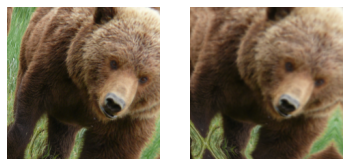

In [ ]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

##### <FONT COLOR=RED> You can see that the image on the right is less well defined and has reflection padding artifacts in the bottom-left corner; also, the grass at the top left has disappeared entirely. We find that, in practice, using presizing significantly improves the accuracy of models and often results in speedups too.
##### <FONT COLOR=RED> The fastai library also provides simple ways to check how your data looks right before training your model, which is an extremely important step. We’ll look at those next.

### __Checking and Debugging a DataBlock__

##### <FONT COLOR=RED> We can never just assume that our code is working perfectly. Writing a `DataBlock` is just like writing a blueprint. You will get an error message if you have a syntax error somewhere in your code, but you have no guarantee that your template is going to work on your data source as you intend. So, before training a model you should always check your data. You can do this using the `show_batch` method:

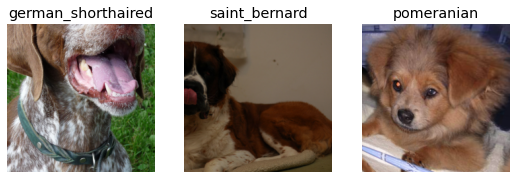

In [ ]:
dls.show_batch(nrows=1, ncols=3)

##### <FONT COLOR=RED> Take a look at each image, and check that each one seems to have the correct label for that breed of pet. Often, data scientists work with data with which they are not as familiar as domain experts may be: for instance, I actually don't know what a lot of these pet breeds are. Since I am not an expert on pet breeds, I would use Google images at this point to search for a few of these breeds, and make sure the images look similar to what I see in this output.

##### <FONT COLOR=RED> If you made a mistake while building your `DataBlock`, it is very likely you won't see it before this step. To debug this, we encourage you to use the `summary` method. It will attempt to create a batch from the source you give it, with a lot of details. Also, if it fails, you will see exactly at which point the error happens, and the library will try to give you some help. For instance, one common mistake is to forget to use a `Resize` transform, so you end up with pictures of different sizes and are not able to batch them. Here is what the summary would look like in that case (note that the exact text may have changed since the time of writing, but it will give you an idea):

##### <FONT COLOR=RED> You can see exactly how we gathered the data and split it, how we went from a filename to a *sample* (the tuple (image, category)), then what item transforms were applied and how it failed to collate those samples in a batch (because of the different shapes).

##### <FONT COLOR=RED> Once you think your data looks right, we generally recommend the next step should be using it to train a simple model. We often see people put off the training of an actual model for far too long. As a result, they don't actually find out what their baseline results look like. Perhaps your problem doesn't need lots of fancy domain-specific engineering. Or perhaps the data doesn't seem to train the model at all. These are things that you want to know as soon as possible.
    
##### <FONT COLOR=RED> For this initial test, we'll use the same simple model that we used in `Chapter 1`:

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.525402,0.325769,0.099459,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.509253,0.276395,0.087280,00:28
1,0.332886,0.209544,0.062923,00:28


##### <FONT COLOR=RED>

##### <FONT COLOR=RED> As we've briefly discussed before, the table shown when we fit a model shows us the results after each epoch of training. Remember, an epoch is one complete pass through all of the images in the data. The columns shown are the average loss over the items of the training set, the loss on the validation set, and any metrics that we requested—in this case, the error rate.

##### <FONT COLOR=RED> Remember that `loss` is whatever function we've decided to use to optimize the parameters of our model. But we haven't actually told fastai what loss function we want to use. So what is it doing? fastai will generally try to select an appropriate loss function based on what kind of data and model you are using. In this case we have image data and a categorical outcome, so fastai will default to using `cross-entropy loss`.

## Cross-Entropy Loss

### Viewing Activations and Labels

In [ ]:
dls.one_batch?

Signature: dls.one_batch()
Docstring: Return one batch from `DataLoader`.
File:      ~/anaconda3/envs/fastai-2.7.9/lib/python3.9/site-packages/fastai/data/load.py
Type:      method


In [ ]:
x,y = dls.one_batch()

##### <FONT COLOR=RED>

In [ ]:
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [ ]:
y, len(y)

(TensorCategory([30, 30,  2,  8, 19, 16,  7,  6, 31, 17, 10, 12, 21, 22,  5, 14, 26, 16,  5, 33, 20,  9, 36, 23, 36,  1,  5, 24, 12,  5, 21, 13,  4, 35, 12,  6, 34,  0,  8,  5, 15, 32, 22, 23,  2,  6,
                  3, 29, 26, 17,  5, 30, 36, 15,  3,  0,  5,  9,  8,  4, 12,  7,  1,  5], device='cuda:0'),
 64)

In [ ]:
learn.get_preds?

Signature:
learn.get_preds(
    ds_idx=1,
    dl=None,
    with_input=False,
    with_decoded=False,
    with_loss=False,
    act=None,
    inner=False,
    reorder=True,
    cbs=None,
    *,
    save_preds: 'Path' = None,
    save_targs: 'Path' = None,
    with_preds: 'bool' = True,
    with_targs: 'bool' = True,
    concat_dim: 'int' = 0,
    pickle_protocol: 'int' = 2,
)
Docstring: Get the predictions and targets on the `ds_idx`-th dbunchset or `dl`, optionally `with_input` and `with_loss`
File:      ~/anaconda3/envs/fastai-2.7.9/lib/python3.9/site-packages/fastai/learner.py
Type:      method


In [ ]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

TensorBase([2.1800e-09, 6.3478e-08, 3.4957e-07, 3.7358e-09, 3.5072e-07, 6.2063e-09, 2.8180e-08, 8.4435e-08, 1.6306e-07, 2.2804e-07, 1.7180e-08, 4.2284e-08, 1.5385e-06, 2.5349e-08, 5.9519e-06,
            8.5665e-07, 4.6064e-05, 5.5584e-10, 1.4655e-07, 2.9210e-07, 1.2173e-07, 2.6024e-07, 3.9784e-08, 4.0045e-06, 9.9162e-09, 5.9080e-05, 9.3982e-10, 1.5619e-07, 1.7763e-08, 7.7895e-08,
            9.9988e-01, 8.7209e-08, 3.1920e-08, 1.8887e-07, 3.3184e-08, 6.1138e-08, 2.2647e-09])

In [ ]:
len(preds[0]),preds[0].sum()

(37, TensorBase(1.0000))

### Softmax

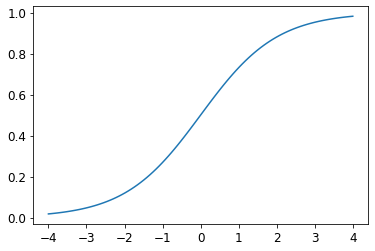

In [ ]:
plot_function(torch.sigmoid, min=-4,max=4)

In [ ]:
#hide
torch.random.manual_seed(42);

In [ ]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [ ]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [ ]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [ ]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log Likelihood

In [ ]:
targ = tensor([0,1,0,1,1,0])

In [ ]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [ ]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [ ]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

/tmp/ipykernel_7828/517540062.py:6: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  t = df.style.hide_index()


3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [ ]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [ ]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

### Taking the Log

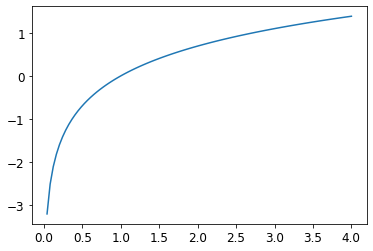

In [ ]:
plot_function(torch.log, min=0,max=4)

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
loss_func(acts, targ)

tensor(1.8045)

In [ ]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [ ]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

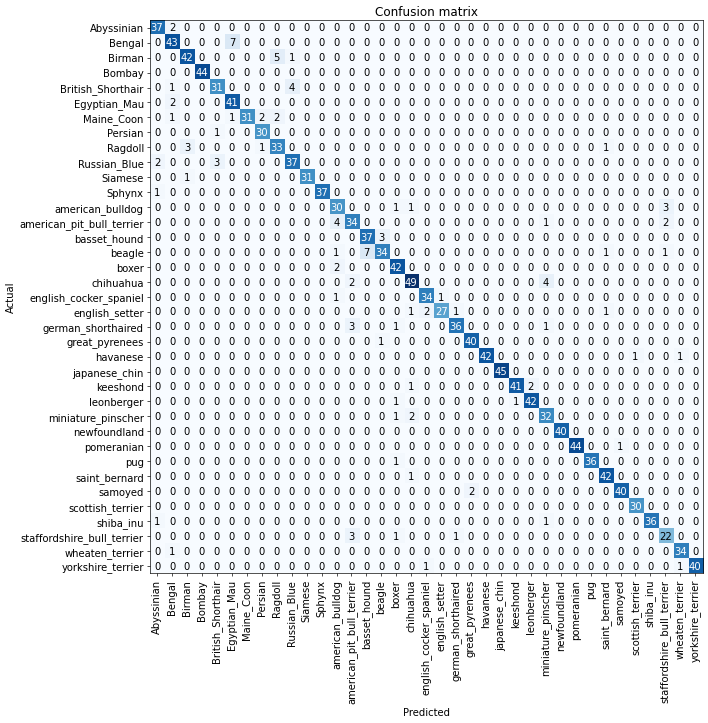

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=5)

NameError: name 'interp' is not defined

## Improving Our Model

### The Learning Rate Finder

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

/home/kgichuhi/anaconda3/envs/fastai-2.7.9/lib/python3.9/site-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/kgichuhi/anaconda3/envs/fastai-2.7.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/kgichuhi/anaconda3/envs/fastai-2.7.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.544096,3.997818,0.418133,00:21


epoch,train_loss,valid_loss,error_rate,time
0,3.586211,2.072836,0.531123,00:27


ValueError: not enough values to unpack (expected 2, got 1)

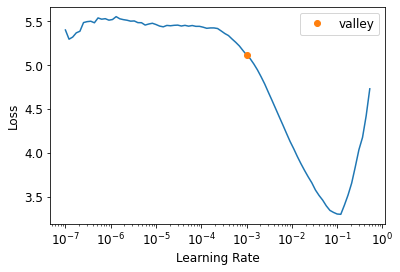

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

NameError: name 'lr_min' is not defined

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.317041,0.388115,0.123139,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.557434,0.358594,0.102165,00:50
1,0.316814,0.234584,0.069689,00:49


### Unfreezing and Transfer Learning

In [ ]:
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    *,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      ~/anaconda3/envs/fastai-2.7.9/lib/python3.9/site-packages/fastai/callback/schedule.py
Type:      method


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.130917,0.291811,0.093369,00:36
1,0.552472,0.228087,0.071042,00:37
2,0.337780,0.216112,0.071042,00:38


In [ ]:
learn.unfreeze()

SuggestedLRs(valley=2.0892961401841603e-05)

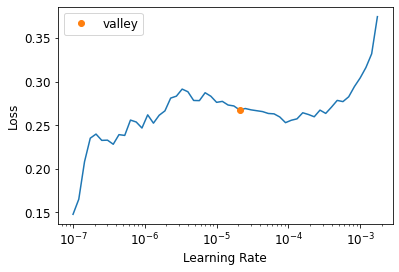

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.270651,0.204050,0.066982,00:49
1,0.260284,0.203509,0.066982,00:51
2,0.202119,0.189067,0.060893,00:52
3,0.205929,0.190002,0.062246,00:50
4,0.185204,0.188609,0.064953,00:50
5,0.186505,0.187741,0.062923,00:49


### Discriminative Learning Rates

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.144289,0.298559,0.097429,00:38
1,0.531449,0.245223,0.079161,00:39
2,0.332430,0.212333,0.066982,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.242441,0.207671,0.064953,00:50
1,0.264182,0.193655,0.058863,00:50
2,0.229041,0.192568,0.061570,00:49
3,0.218260,0.188090,0.060217,00:49
4,0.190141,0.182262,0.056834,00:50
5,0.173558,0.181165,0.062246,00:49
6,0.163796,0.182330,0.052774,00:49
7,0.152561,0.179299,0.054127,00:48
8,0.139176,0.183089,0.056157,00:51
9,0.126163,0.180053,0.058187,00:51


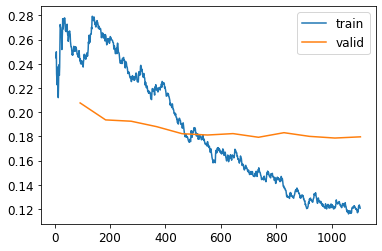

In [ ]:
learn.recorder.plot_loss()

### Selecting the Number of Epochs

### Deeper Architectures

In [ ]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

NameError: name 'dls' is not defined

## Conclusion

## Questionnaire

1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?
1. If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book's website for suggestions.
1. What are the two ways in which data is most commonly provided, for most deep learning datasets?
1. Look up the documentation for `L` and try using a few of the new methods that it adds.
1. Look up the documentation for the Python `pathlib` module and try using a few methods of the `Path` class.
1. Give two examples of ways that image transformations can degrade the quality of the data.
1. What method does fastai provide to view the data in a `DataLoaders`?
1. What method does fastai provide to help you debug a `DataBlock`?
1. Should you hold off on training a model until you have thoroughly cleaned your data?
1. What are the two pieces that are combined into cross-entropy loss in PyTorch?
1. What are the two properties of activations that softmax ensures? Why is this important?
1. When might you want your activations to not have these two properties?
1. Calculate the `exp` and `softmax` columns of <<bear_softmax>> yourself (i.e., in a spreadsheet, with a calculator, or in a notebook).
1. Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?
1. What is the value of log(-2)? Why?
1. What are two good rules of thumb for picking a learning rate from the learning rate finder?
1. What two steps does the `fine_tune` method do?
1. In Jupyter Notebook, how do you get the source code for a method or function?
1. What are discriminative learning rates?
1. How is a Python `slice` object interpreted when passed as a learning rate to fastai?
1. Why is early stopping a poor choice when using 1cycle training?
1. What is the difference between `resnet50` and `resnet101`?
1. What does `to_fp16` do?

### Further Research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Look on the forums and the book's website to see what other students have achieved with this dataset, and how they did it.